# PID with FF simulation

## Import libs

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
from scipy.optimize import minimize

import package_DBR
from package_LAB import *
from package_DBR import *

## Simulation params

In [76]:
TSim = 2200
Ts = 1.0
N = int(TSim/Ts) + 1

# Initial working points 
MV0 = 50
DV0 = 50
PV0 = 12

# Paths
SPPath = {0: 12, 60: 40, 1300: 25}
DVPath = {0: 0}

# Parameters for input-output dynamics
Kp = 0.57
T1p = 172.4
T2p = 2.8
Thetap = 2.0

# Parameters for disturbance dynamics
Kd = 0.29
T1d = 127.9
T2d = 21.8
Thetad = 12.4

# Parameters for the PID controller 
alpha = 0.5
gamma = 0.6
Tc = gamma * T1p
Kc, Ti, Td = IMC_Tuning(Kp, Thetap, Tc, T1p, T2p)
discretisation = ["TRAP", "TRAP"]


## Determine PID gains with IMC tuning

In [77]:
Kc = 0
Ti = 0
Td = 0

Kc,Ti,Td = IMC_Tuning(Kp, Tc, Thetap, T1p, T2p)
print("Kc = {}, ti = {}, td = {}".format(Kc, Ti, Td))

Kc = 2.915102627585657, ti = 175.20000000000002, td = 2.755251141552511


## Simulate

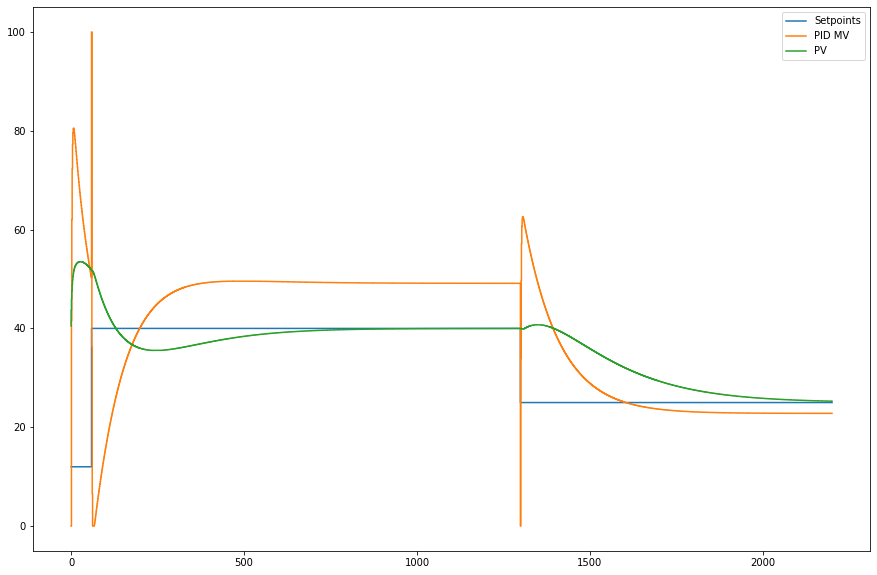

In [78]:
PV = []
MV = {"MV" : [], "MVp" : [], "MVi": [],  "MVd": [], "E" : []}

N = int(TSim/Ts)+1

t = []
SP = []
DV = []

MVDelay = []
PV1p = []
PV2p = []

DVDelay = []
PV1d = []
PV2d = []

for i in range(0,N):
  t.append(i*Ts)
  SelectPath_RT(SPPath,t,SP)
  SelectPath_RT(DVPath,t,DV)


for i in range(0, N):
  # PID controller
  PID_OUT = PID_RT(PV, SP[i], MV, Ts, Kc, Ti, Td, alpha, discretisation, PVinit=PV0)
  MV["MV"].append(PID_OUT["MV"])
  MV["MVp"].append(PID_OUT["MVp"])
  MV["MVi"].append(PID_OUT["MVi"])
  MV["MVd"].append(PID_OUT["MVd"])
  MV["E"].append(PID_OUT["E"])

  # Process Dynamics
  Delay_RT(MV["MV"], Thetap, Ts, MVDelay, MV0)
  FO_RT(MVDelay, Kp, T1p, Ts, PV1p, PV0)
  FO_RT(PV1p, 1, T2p, Ts, PV2p)

  # Disturbance dynamics
  Delay_RT(DV - DV0*np.ones_like(DV), Thetad, Ts, DVDelay, DV0)
  FO_RT(DVDelay, Kp, T1d, Ts, PV1d)
  FO_RT(PV1d, 1, T2d, Ts, PV2d)

  PV.append(PV2p[-1] + PV2d[-1] + PV0 + Kp * MV0)
  

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(10)

plt.step(t, np.array(SP), label='Setpoints')
plt.step(t, np.array(MV["MV"]), label='PID MV')
plt.step(t, np.array(PV), label='PV')

plt.legend(loc='upper right')

plt.show()